# **Deep Research with Bing Search & Scraping**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow now includes a dedicated scraping phase for extracting and cleaning web content:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Web Content Scraping** - Extracting, cleaning, and filtering relevant content from web pages using a ScraperAgent
4. **Content Analysis** - Summarizing scraped results and extracting key insights
5. **Report Generation** - Creating detailed research reports with proper citations
6. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- WebScraperAgent - Extracts, cleans, and filters relevant content from web pages
- SummaryAgent - Extracts key insights from scraped content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import os
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class ScrapedWebPage(BaseModel):
    url: str = Field(..., description="The original URL that was scraped")
    title: Optional[str] = Field(None, description="The page title (if available, else None)")
    main_content: Optional[str] = Field(None, description="The main textual content of the page, cleaned and potentially truncated (if available, else None)")
    source: Optional[str] = Field(None, description="The name of the source (if available, else None)")
    published_date: Optional[str] = Field(None, description="YYYY-MM-DD (if available, else None)")
    scrape_error: Optional[str] = Field(None, description="Error message if scraping failed, else None")
    # Fields below might be added by the agent based on instructions, not the tool directly
    extraction_method: Optional[str] = Field(None, description="How content was extracted (e.g., 'tool_extracted', 'agent_filtered')") 
    relevance_score_agent: Optional[float] = Field(None, description="Agent's assessment of relevance (0-10)")
    matched_sections: Optional[List[str]] = Field(None, description="Sections identified by the agent as relevant")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
# from azure.ai.projects.models import BingGroundingTool

# bing_connection = project_client.connections.get(
#     connection_name=os.environ["BING_CONNECTION_NAME"]
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="BingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model="gpt-4o",
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions="""You are a helpful research assistant. 
# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results."""
# )

If you already have an Azure AI Agent, run this cell to update it's instructions with today's date.

In [6]:
import datetime

current_date = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-05-26.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


**OpenAI Agents**

In [8]:
from agents import (
    Agent,
    ModelSettings
)

from common.utils_scraping import scrape_web_page

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.

    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 4 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 2 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

web_scraper_agent = Agent(
    name="WebScraperAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are a robust, context-aware web scraping specialist. Your primary tool is 'scrape_web_page'.

    Your input is a JSON string containing: 'url', 'subtopic', 'user_query', 'search_result_title', 'visited_urls', and 'max_content_length'. Parse this JSON to get the necessary information.

    **Workflow:**
    1.  **Parse Input:** Extract 'url', 'user_query', 'subtopic', 'search_result_summary', and 'max_content_length' from the input JSON string.
    2.  **Call Scraping Tool:** Call the `scrape_web_page` tool with the 'url' and 'max_content_length'.
    3.  **Analyze Tool Output:** Receive the dictionary from the tool containing `url`, `title`, `main_content`, `source`, `published_date`, `scrape_error`.
    4.  **Contextual Filtering (If Content Exists and No Error):**
        - If `scrape_error` is None and `main_content` exists:
            - Review the `main_content`.
            - Use the `user_query`, `subtopic`, and `search_result_summary` to identify ONLY the most relevant paragraphs or sections.
            - If the entire `main_content` seems relevant or is short, keep it all.
            - If filtering, replace `main_content` with ONLY the relevant extracted parts. Set `extraction_method` to 'agent_filtered'.
            - Estimate a `relevance_score_agent` (0-10).
            - Optionally list `matched_sections`.
        - If `scrape_error` is present, ensure the `scrape_error` field in your output reflects the tool's error.
    5.  **Format Output:** Return a SINGLE JSON object matching the `ScrapedWebPage` Pydantic model, including all fields based on the tool's output and your filtering. If the tool failed, `main_content` should be None/empty, and `scrape_error` should be set.
    6.  **Return JSON object:** Return ONLY the final object formatted as a single, valid JSON. Do NOT add any explanatory text before or after the JSON.

    **Constraints:**
    - Your final output MUST be ONLY a valid JSON representing the scraped and processed data.
    - Adhere strictly to the field names defined in the conceptual `ScrapedWebPage` structure when creating the JSON.
    - Prioritize accuracy and relevance based on the provided context.
    """,
    model=chatModel,
    model_settings=chatModelSettings,
    tools=[scrape_web_page],
    output_type=ScrapedWebPage
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [9]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Web Content Scraping** → WebScraperAgent extracts, cleans, and filters relevant content from web pages
5. **Analysis** → SummaryAgent processes scraped results, extracting key insights while preserving technical details
6. **Synthesis** → ResearchAgent creates well-structured report with proper citations
7. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
8. **Revision** → If needed, research report undergoes improvement cycles based on feedback
9. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

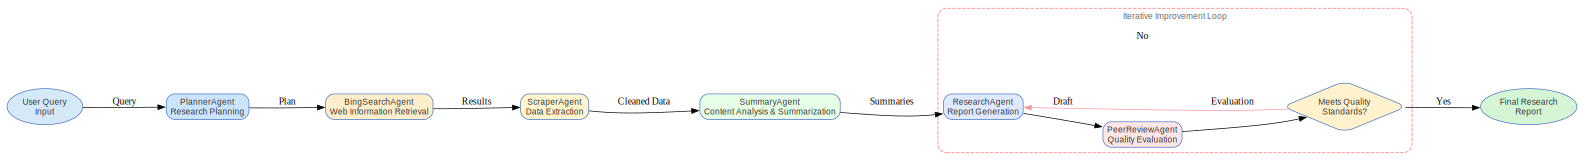

In [10]:
from common.helper import create_research_workflow_diagram_scraper

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram_scraper()
workflow_diagram

Let's start with a sample research query.

In [24]:
user_query="What big industries will AI have the most affected on?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [25]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [26]:
plan.final_output.research_tasks[0].search_queries

['industries most affected by artificial intelligence',
 'which sectors are being transformed by AI',
 'AI impact on major industries 2024',
 'top industries disrupted by AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. Multiple search queries are sent to gather diverse perspectives.
2. The agent returns structured search results with titles, summaries, relevance scores, and URLs.
3. Results are organized by subtopic for further processing.

This step leverages Azure AI Projects with Bing Search integration to identify promising sources.

In [27]:
import os
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.create_thread()
            message = project_client.agents.create_message(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.create_and_process_run(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.delete_thread(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 4/4 [02:39<00:00, 39.97s/it]


In [28]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 16

Actually total search queries: 16



### Step 3: Web Content Scraping

The WebScraperAgent processes the URLs and metadata returned by the BingSearchAgent. For each subtopic:

1. Only URLs with a high enough relevance score are selected for scraping.
2. The WebScraperAgent visits each selected URL and extracts the most relevant content, guided by the user query, subtopic, and search result summary.
3. Extracted content is cleaned, deduplicated, and enriched with metadata such as title, source, published date, and extraction method.
4. The resulting structured data is organized by subtopic for downstream analysis and summarization.

This step ensures that only the most promising and contextually relevant web content is collected, providing a high-quality foundation for subsequent summarization and synthesis.

In [29]:
from typing import Set

class ScraperAgentInput(BaseModel):
    url: str
    subtopic: str
    user_query: str
    search_result_title: str
    visited_urls: Set[str] = Field(default_factory=set)
    max_content_length: int = 4000

In [30]:
# TODO: Implement a threshold for relevance score 

# --- Scraping Phase ---
urls_to_process_map = {}

print("Preparing scrape tasks...")
for subtopic_result in search_results:
    subtopic = subtopic_result["subtopic"]
    for query_result in subtopic_result["queries"]:
        query = query_result["query"]
        for result in query_result["results"]:
            if result["url"] not in urls_to_process_map:
            # if result.relevance_score >= MIN_RELEVANCE_SCORE and result.url not in urls_to_process_map:
                urls_to_process_map[result["url"]] = {
                    "subtopic": subtopic,
                    "query": query,
                    "search_result_title": result["title"]
                }

visited_urls_tracker = set(urls_to_process_map.keys())
print(f"Found {len(urls_to_process_map)} unique URLs above threshold to scrape.")

Preparing scrape tasks...
Found 40 unique URLs above threshold to scrape.


In [31]:
from itertools import islice

MAX_SCRAPE_CONTENT_LENGTH = 4000 # Max characters for scrape tool

scrape_tasks = []
num_urls_to_scrape = len(urls_to_process_map)

for url, context in tqdm(islice(urls_to_process_map.items(), num_urls_to_scrape),
                         desc="Preparing scrape tasks",
                         total=num_urls_to_scrape):
    agent_input_model = ScraperAgentInput(
        url=url,
        subtopic=context["subtopic"],
        user_query=context["query"],
        search_result_title=context["search_result_title"],
        visited_urls=visited_urls_tracker,
        max_content_length=MAX_SCRAPE_CONTENT_LENGTH
    )

    scrape_response = await Runner().run(
        starting_agent=web_scraper_agent,
        input=f"Scrape data from the provided URL: {agent_input_model.model_dump_json()}"
    )
    scrape_tasks.append(scrape_response.final_output)

Preparing scrape tasks:   8%|▊         | 3/40 [00:20<04:23,  7.13s/it]WARNING:trafilatura.utils:invalid ZSTD file
ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None
ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
Preparing scrape tasks:  12%|█▎        | 5/40 [00:28<03:07,  5.37s/it]WARNING:trafilatura.utils:invalid ZSTD file
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
Preparing scrape tasks:  15%|█▌        | 6/40 [00:38<03:50,  6.79s/it]WARNING:trafilatura.utils:invalid ZSTD file
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
Preparing scrape tasks:  30%|███     

### Step 4: Content Analysis and Summarization

For each scraped result, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the cleaned web content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms high-quality scraped data into structured, information-rich summaries that will form the basis of our research report.

In [32]:
from common.utils_summary import collect_contents_and_citations, summarize_content
summarize_per_webpage = False  # True will summarize per web page, False will summarize per subtopic

# Build a lookup for scraped content (using attribute access)
scraped_content_by_url = {
    item.url: item.main_content
    for item in scrape_tasks
    if getattr(item, "main_content", None)
}

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    contents, citations = collect_contents_and_citations(subtopic_result, scraped_content_by_url)
    summaries = await summarize_content(contents, summary_agent, Runner, summarize_per_webpage)
    if summarize_per_webpage:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })
    else:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })

# Filter out empty summaries
mapped_chunks = [c for c in mapped_chunks if c['summaries']]

Summarizing subtopics: 100%|██████████| 4/4 [01:09<00:00, 17.44s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [33]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [34]:
from agents import HandoffCallItem

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [35]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# The Transformative Impact of Artificial Intelligence on Major Industries: Nature, Scale, and Implications

## Introduction

Artificial intelligence (AI) has rapidly evolved from a niche technological curiosity to a central driver of industrial transformation, economic growth, and societal change. As we approach the mid-2020s, AI is no longer confined to experimental pilots or isolated use cases; it is becoming deeply embedded in the core operations and strategic priorities of leading organizations across the globe. This comprehensive report examines the industries most significantly affected by AI, the nature and extent of these impacts, the current and emerging applications driving change, and the future trends poised to reshape the global economic landscape. Drawing on recent data, expert forecasts, and industry case studies, the analysis provides a nuanced, integrated perspective on how AI is redefining value creation, competitive advantage, and the very fabric of work and society.

## Identification of Major Industries Impacted by AI

### Overview of Industry Transformation

AI’s influence is pervasive, but its impact is particularly pronounced in several key sectors: healthcare, finance, retail, manufacturing, automotive, logistics, education, and creative industries. These sectors are not only adopting AI at scale but are also experiencing fundamental shifts in their operating models, value propositions, and workforce dynamics. The convergence of AI with other digital technologies—such as the Internet of Things (IoT), cloud computing, and advanced analytics—further amplifies its transformative potential, enabling new forms of automation, personalization, and data-driven decision-making.

### Healthcare

Healthcare stands at the forefront of AI-driven transformation. The integration of AI into diagnostics, personalized medicine, operational efficiency, and patient management is revolutionizing care delivery. AI-powered imaging systems, predictive analytics, and robotic-assisted surgeries are enhancing accuracy, reducing costs, and making advanced care more accessible. The sector is also witnessing the rise of digital health ecosystems, where AI-driven platforms support chronic disease management, real-time monitoring, and patient engagement on an unprecedented scale [1], [2].

### Finance

The finance industry is undergoing a radical metamorphosis, leveraging AI for advanced risk management, fraud detection, autonomous trading, and personalized financial services. AI’s ability to process vast datasets in real time enables financial institutions to identify patterns, anticipate risks, and deliver tailored solutions to clients. The adoption of generative AI and intelligent chatbots is streamlining regulatory compliance and customer service, positioning AI as a core differentiator for competitive advantage [2], [3].

### Retail

Retailers are harnessing AI to deliver hyper-personalized shopping experiences, optimize inventory and supply chains, and automate marketing and customer service. AI-driven recommendation engines, virtual assistants, and demand forecasting tools are enhancing both consumer satisfaction and operational efficiency. The sector is moving from experimental pilots to scalable, business-aligned AI deployments that directly support strategic objectives [1], [2].

### Manufacturing

Manufacturing is embracing the era of Industry 4.0, where AI and IoT converge to create smart factories. AI monitors production lines, predicts equipment failures, and optimizes resource allocation, reducing downtime and improving product quality. The integration of AI-powered robotics and advanced vision systems is transforming quality control, safety, and workforce roles [2], [4].

### Automotive

The automotive sector is experiencing a paradigm shift with the advent of AI-enabled autonomous vehicles, advanced driver-assistance systems (ADAS), and smart manufacturing. AI is central to the development of self-driving cars, predictive maintenance, and personalized in-vehicle experiences. The market for automotive AI is projected to exceed $47 billion by 2033, with compound annual growth rates above 25% [5], [6].

### Logistics

Logistics and supply chain management are being revolutionized by AI-driven demand forecasting, route optimization, warehouse automation, and predictive maintenance. The sector is achieving measurable reductions in costs, downtime, and inventory levels, while enhancing customer-centricity and global reach [7], [8].

### Education and Creative Industries

Education is leveraging AI for intelligent tutoring, personalized learning, and administrative automation, while creative industries are adopting generative AI for content creation, design, and media production. These sectors exemplify the broadening scope of AI’s impact beyond traditional industrial domains [9], [10].

### Comparative Assessment

The following table provides a comparative overview of AI’s impact across major industries, highlighting key applications and projected economic value:

| Industry      | Key AI Applications                                 | Projected Economic Value (2030) | Notable Trends                  |
|---------------|-----------------------------------------------------|-------------------------------|---------------------------------|
| Healthcare    | Diagnostics, personalized medicine, workflow automation | $150B annual savings (US)      | Digital health ecosystems, femtech |
| Finance       | Risk management, fraud detection, robo-advisors     | $447B annual savings           | Generative AI, compliance automation |
| Retail        | Personalization, inventory optimization, chatbots   | $800B value creation           | Hyper-personalization, marketing automation |
| Manufacturing | Smart factories, predictive maintenance, robotics   | $1.5–$2.2T annual value        | Industry 4.0, quality control    |
| Automotive    | Autonomous driving, predictive maintenance, personalization | $47B+ market size (2033)       | Level 3+ autonomy, smart cabins  |
| Logistics     | Demand forecasting, route optimization, warehouse automation | $1.3–$2T annual value (global) | Real-time data, cross-border platforms |
| Education     | Intelligent tutoring, personalized learning         | $100B+ (global)                | AI-driven content, adaptive platforms |
| Creative      | Generative design, media production                 | $2.6–$4.4T (GenAI, all sectors)| Synthetic content, automation    |

*Sources: [1]–[10]*

## Nature and Extent of AI Impact in Key Industries

### Healthcare: Toward Integrated, AI-Driven Digital Health

The definition of digital health is shifting from isolated telemedicine and digital therapeutics toward integrated, AI-powered solutions that enhance patient-provider relationships and support sustainable economics. AI is rapidly expanding the capabilities of digital health, influencing everything from personalized care and chronic disease management to workflow automation and diagnostic accuracy. Real-time monitoring devices, advanced sleep-tracking, and femtech innovations are transforming patient support, while AI tools empower providers with personalized treatment and evidence-based decision-making [11].

AI’s impact on healthcare is both quantitative and qualitative. Predictive analytics enable early identification of health risks, reducing hospitalizations and improving outcomes. AI-powered imaging systems achieve diagnostic accuracy rates exceeding 95%, while robotic surgeries and virtual assistants are making advanced care more accessible. Operationally, AI streamlines administrative tasks, reduces human error, and optimizes supply chains, contributing to significant cost savings and efficiency gains. The integration of smart implants and wearable devices allows for continuous, remote monitoring, facilitating proactive management of chronic conditions and enhancing quality of life.

A notable development is the rise of femtech, which addresses long-standing gaps in women’s healthcare. Innovations are focusing on redesigning traditional medical hardware and creating interoperable ecosystems that pool women’s health data, driving improved outcomes. AI-driven decision-support tools are becoming mainstream, granting clinicians immediate access to the latest research and treatment guidelines. At the organizational level, AI is orchestrating entire workflows, managing complete patient episodes across multiple departments, and continuously learning to drive improvements in efficiency and clinical outcomes.

### Finance: Autonomous, Secure, and Personalized Services

In finance, AI is central to risk management, fraud detection, autonomous trading, and personalized financial services. AI systems analyze enormous volumes of financial data in real time, identifying patterns and anomalies that would be impossible for humans to detect. This capability is particularly valuable for fraud detection, where AI can flag suspicious transactions instantly, reducing financial crime and enhancing security for both institutions and customers.

Advanced risk models powered by machine learning enable financial institutions to better anticipate and mitigate potential threats. Automated financial planning and robo-advisors are becoming more sophisticated, offering personalized investment advice and financial strategies around the clock. AI-driven recommendation systems and credit risk assessment tools streamline operations and improve customer engagement. Generative AI is being used to synthesize large datasets for analysts, automate regulatory compliance, and support customer service through intelligent chatbots. The finance sector’s data-driven nature makes it particularly well-suited to AI adoption, and by 2025, AI will be a core differentiator for competitive advantage in the industry [2], [3].

### Retail: Hyper-Personalization and Operational Optimization

Retailers are leveraging AI to deliver hyper-personalized shopping experiences, both online and in-store. By 2025, AI will enable retailers to analyze consumer behavior, predict purchasing trends, and tailor product recommendations, discounts, and marketing content to individual preferences. AI-powered virtual assistants and chatbots are enhancing customer service by providing instant support, order tracking, and personalized suggestions, freeing human staff for higher-value tasks.

Operationally, AI optimizes inventory management, pricing, and demand forecasting. By analyzing sales data and market trends, AI systems help retailers maintain optimal stock levels, reduce waste, and improve supply chain efficiency. Marketing teams are using generative AI to automate campaign creation, content generation, and customer segmentation, increasing both scale and effectiveness. The retail industry is also seeing a shift from experimental AI pilots to scalable, business-aligned use cases. Retailers are focusing on integrating AI into strategic priorities—such as customer engagement, digital commerce, and operational efficiency—rather than deploying AI for its own sake [2], [3].

### Manufacturing: Smart Factories and Predictive Maintenance

Manufacturing is embracing Industry 4.0, where AI and the Internet of Things (IoT) converge to create smart factories. AI monitors production lines in real time, predicts equipment failures through predictive maintenance, and optimizes inventory and supply chain management. These capabilities reduce downtime, lower costs, and improve product quality while minimizing human error.

AI-powered robots are taking over repetitive and hazardous tasks, allowing human workers to focus on more complex and creative roles. Dynamic scheduling and real-time data analysis enable manufacturers to optimize resource allocation, reduce waste, and maintain continuous production. AI vision systems are enhancing quality control by detecting defects that might escape human inspectors. Predictive maintenance solutions, such as Siemens’ Senseye, integrate with SCADA, MES, ERP, and CMMS platforms to monitor thousands of assets in real time, delivering results such as a 12% reduction in unplanned downtime within 12 weeks of deployment [4], [5].

### Automotive: Autonomous Vehicles and Smart Mobility

The automotive industry is experiencing a paradigm shift with the advent of AI-enabled autonomous vehicles, advanced driver-assistance systems (ADAS), and smart manufacturing. AI is central to the development of self-driving cars, predictive maintenance, and personalized in-vehicle experiences. The market for automotive AI is projected to exceed $47 billion by 2033, with compound annual growth rates above 25% [5], [6].

AI is central to the evolution of autonomous vehicles (AVs) and ADAS. In 2025, Level 3 and Level 4 autonomous driving are gaining commercial traction, with Mercedes-Benz achieving regulatory approval for Level 3 autonomy in Germany and parts of the U.S. Companies like Waymo and Cruise are expanding robotaxi operations, leveraging AI for route optimization, real-time decision-making, and safety. AI-powered perception systems—combining LiDAR, cameras, radar, and neural networks—enable vehicles to interpret complex environments and make split-second decisions. The global autonomous vehicle market is expected to reach $126.8 billion by 2030 (CAGR 22.3% from 2024). Notably, Waymo’s AI-driven vehicles have demonstrated an 85% reduction in crash-related injuries compared to human drivers, with only three injury-causing accidents over more than 7 million miles [5], [6].

### Logistics: Intelligent Supply Chains and Automation

Logistics and supply chain management are being revolutionized by AI-driven demand forecasting, route optimization, warehouse automation, and predictive maintenance. The sector is achieving measurable reductions in costs, downtime, and inventory levels, while enhancing customer-centricity and global reach. AI-driven route optimization analyzes real-time traffic and weather data to reduce fuel costs and delivery times, supporting sustainability goals. Companies using AI in logistics report operational cost reductions of up to 50% and improved safety rates by 90% [7], [8].

AI-powered robotics and computer vision are transforming warehouses into intelligent, automated hubs. These systems manage inventory, sort and organize products, and enhance worker safety. Automated document processing (OCR) accelerates shipment handling and reduces manual errors. Predictive maintenance in logistics, powered by AI and IoT sensors, detects anomalies in equipment performance (heat, vibration, cycle times), reducing downtime by 50%, breakdowns by 70%, and maintenance costs by 25%. For example, BMW’s AI-supported systems save over 500 minutes of disruption per plant annually [7], [8].

### Education and Creative Industries: Personalization and Generative AI

Education is leveraging AI for intelligent tutoring, personalized learning, and administrative automation, while creative industries are adopting generative AI for content creation, design, and media production. These sectors exemplify the broadening scope of AI’s impact beyond traditional industrial domains. AI-powered education tools are anticipated to democratize access to quality learning, reducing education costs by 20–30% and potentially increasing workforce participation among women and underrepresented groups by 15–20% [9], [10].

## Current and Emerging AI Applications in These Industries

### Healthcare: AI-Driven Digital Health Ecosystems

The maturation of AI technologies, particularly generative AI (GenAI), is poised to influence every facet of healthcare. AI’s expanding role is evident in its application to chronic disease management—such as heart failure, diabetes, and mental health—where digital solutions are being leveraged to close persistent gaps in care. The integration of smart implants and wearable devices allows for continuous, remote monitoring of key biological functions like cardiac activity and blood glucose levels. This real-time data collection not only facilitates proactive management of chronic conditions but also enhances patients’ quality of life by enabling timely interventions [11].

Sleep, increasingly recognized as a critical biomarker for overall health, is another area where digital health is innovating. Advanced sleep-tracking technologies are being developed to provide more accurate and actionable insights, reflecting a broader trend toward individualized health monitoring. Digital platforms and mobile apps are giving patients unprecedented control over their health, offering predictive analytics to anticipate flare-ups and suggesting real-time interventions. AI chatbots and virtual assistants are expected to become mainstream, providing immediate answers to health-related questions and supporting patient engagement.

A notable development is the rise of femtech, which seeks to address long-standing gaps in women’s healthcare. Innovations are focusing on redesigning traditional medical hardware, such as the speculum, with the female experience at the center. This shift is urgently needed, as evidenced by a recent BCG X survey indicating that only 41% of women globally feel their specific health concerns are adequately addressed by existing services. The maturation of partnerships between femtech and wellness brands is fostering interoperable ecosystems that pool women’s health data, with the potential to drive significantly improved outcomes.

On the provider side, AI is empowering clinicians by enabling the processing of vast quantities of personalized patient data. This supports the delivery of highly tailored medical treatments, informed by continuous monitoring, lifestyle factors, and genetic information. Providers can dynamically adjust care plans in real time, enhancing both efficacy and patient safety. AI-powered decision-support tools are set to become mainstream in 2025, granting clinicians immediate access to the latest evidence-based research and treatment guidelines. GenAI applications are expected to accelerate diagnostic processes, reduce errors, and improve the accuracy of outcome predictions, thus streamlining patient care delivery.

At the organizational level, the role of AI is expanding from automating discrete tasks to orchestrating entire workflows. Instead of isolated tools for note-taking or appointment scheduling, intelligent AI agents will manage complete patient episodes—from intake through treatment planning—across multiple departments. These systems will continuously learn and adapt, driving improvements in both efficiency and clinical outcomes at the patient and system levels.

### Automotive: Autonomous Driving, Smart Manufacturing, and Personalization

AI is fundamentally transforming the automotive industry, driving efficiency, cost savings, safety, and innovation across the entire value chain. In the realm of autonomous driving, AI adoption is accelerating in Level 3+ autonomy, predictive maintenance, smart manufacturing, generative design, and personalized in-vehicle experiences. The global automotive AI market is projected to reach between $47.3 billion (by 2033, IMARC Group) and $48.59 billion (by 2034, various sources), with compound annual growth rates (CAGR) ranging from 24.1% to 29.61% [5], [6].

#### Autonomous Driving and Advanced Driver-Assistance Systems (ADAS)

AI is central to the evolution of autonomous vehicles (AVs) and ADAS. In 2025, Level 3 and Level 4 autonomous driving are gaining commercial traction, with Mercedes-Benz achieving regulatory approval for Level 3 autonomy in Germany and parts of the U.S. Companies like Waymo and Cruise are expanding robotaxi operations, leveraging AI for route optimization, real-time decision-making, and safety. AI-powered perception systems—combining LiDAR, cameras, radar, and neural networks—enable vehicles to interpret complex environments and make split-second decisions. The global autonomous vehicle market is expected to reach $126.8 billion by 2030 (CAGR 22.3% from 2024). Notably, Waymo’s AI-driven vehicles have demonstrated an 85% reduction in crash-related injuries compared to human drivers, with only three injury-causing accidents over more than 7 million miles [5], [6].

#### Manufacturing, Predictive Maintenance, and Quality Control

AI is revolutionizing automotive manufacturing through smart factories, predictive maintenance, and AI-driven quality control. Machine learning (ML) and deep learning (DL) are used to analyze vast datasets from thousands of connected assets—such as stamping machines, robotic welders, and inspection systems. Predictive maintenance solutions, like Siemens’ Senseye, integrate with SCADA, MES, ERP, and CMMS platforms to monitor over 10,000 assets in real time, delivering results such as a 12% reduction in unplanned downtime within 12 weeks of deployment. AI-based image recognition systems, like those in BMW’s “Factory of the Future,” achieve defect detection accuracy above 98%. AI-driven manufacturing can reduce operational costs by up to 20% (McKinsey), and predictive maintenance can cut maintenance costs by 10-40% and unplanned downtime by up to 50% (Deloitte) [5], [6].

#### In-Vehicle Experience and Personalization

AI is transforming the in-cabin experience through natural language processing (NLP), voice assistants (Amazon Alexa, Google Assistant, Mercedes-Benz MBUX), and real-time edge AI processing (NVIDIA, Qualcomm). Vehicles are becoming “smartphones on wheels,” offering personalized settings, predictive suggestions, and adaptive infotainment. By 2025, AI-powered personalization is expected to become mainstream, with vehicles remembering user preferences and adapting cabin environments accordingly.

#### Economic Impact and Adoption Metrics

AI adoption is widespread: 54 million cars with some level of automation were on the roads last year, up from 31 million in 2019. 75% of automotive companies are experimenting with generative AI, with the remainder planning adoption within a year. AI-driven transformations have reduced automotive industry costs by 8-12%, with potential returns on investment of 10-15x within three years. In dealerships, 81% anticipate increased AI budgets for 2025, and 37% report revenue increases of 20-30% due to AI solutions [5], [6].

#### Supply Chain and Logistics Integration

AI enhances supply chain visibility, real-time tracking, and inventory optimization. AI-driven analytics enable proactive management of inventory, supplier performance, and logistics, reducing stockouts and improving customer satisfaction. In the aftermarket, AI automates diagnostics, predictive parts ordering, and customer service, further streamlining operations.

### Logistics: Demand Forecasting, Route Optimization, and Warehouse Automation

AI is revolutionizing logistics by enabling accurate demand forecasting (reducing errors by 20-50%), optimizing inventory levels (reductions of 35%), and boosting service levels (up to 65%). AI-driven route optimization analyzes real-time traffic and weather data to reduce fuel costs and delivery times, supporting sustainability goals. Companies using AI in logistics report operational cost reductions of up to 50% and improved safety rates by 90% [7], [8].

AI-powered robotics and computer vision are transforming warehouses into intelligent, automated hubs. These systems manage inventory, sort and organize products, and enhance worker safety. Automated document processing (OCR) accelerates shipment handling and reduces manual errors. Predictive maintenance in logistics, powered by AI and IoT sensors, detects anomalies in equipment performance (heat, vibration, cycle times), reducing downtime by 50%, breakdowns by 70%, and maintenance costs by 25%. For example, BMW’s AI-supported systems save over 500 minutes of disruption per plant annually [7], [8].

AI-driven platforms like ShipToBox.com streamline global shopping and shipping, offering real-time tracking, customs automation, and embedded fintech solutions for seamless international commerce. AI enhances customer experiences through proactive notifications, personalized service, and adaptive logistics workflows. AI adoption in logistics could generate $1.3–$2 trillion per year in economic value over the next two decades. Companies like Microsoft are providing reference architectures and AI-enhanced cloud solutions to accelerate digital transformation across inbound and outbound logistics, warehouse management, and customer service [7], [8].

### Cross-Industry Trends: Generative AI, Data Quality, and Strategic Alignment

A significant trend across all industries is the rapid adoption of generative AI (gen AI) and multimodal AI agents. These technologies are moving from experimental pilots to practical, value-generating deployments. Use cases include AI-powered search, customer experience personalization, content generation, and even deepfake defense. According to a Google Cloud-commissioned study, about one-third of organizations are still evaluating or testing gen AI use cases, but momentum is building as executives recognize AI’s potential as a business differentiator [2], [3].

The success of AI initiatives is increasingly tied to data quality and integration. Organizations are investing heavily in improving data infrastructure, recognizing that effective AI relies on high-quality, well-integrated data. This shift marks a departure from previous attitudes that dismissed data projects as low priority. Executives are now challenged to build robust AI strategies that align with core business objectives, select appropriate AI models, and navigate cultural and organizational changes. The boardroom is as involved in AI decisions as the IT department, reflecting the strategic importance of AI for future competitiveness [2], [3].

## Future Trends and Forecasts for AI in Major Industries

### Macroeconomic Impact and Regional Dynamics

Artificial intelligence is poised to be a transformative force for the global economy, with projections indicating a contribution of up to $15.7 trillion by 2030—surpassing the current combined output of China and India. This value will be realized through two main channels: $6.6 trillion from labor productivity improvements and $9.1 trillion from consumption-side effects, such as enhanced product personalization, variety, and affordability. Notably, 45% of the total economic gains by 2030 are expected to stem from product enhancements that stimulate consumer demand [12], [13].

Regionally, the economic impact will be concentrated, with China and North America accounting for nearly 70% of global gains. China is forecasted to see a 26% GDP boost, translating to $10.7 trillion, while North America is expected to experience a 14.5% increase. These gains are attributed to early and strategic investments in AI technologies, rapid adoption, and leadership in innovation [12], [13].

### Industry Transformations and Value Creation

AI is already reshaping industries, with the most advanced adoption seen in banking and finance, retail and eCommerce, media and marketing, and IT. In healthcare, AI-powered diagnostics, personalized medicine, and operational efficiencies are projected to save $150 billion annually in the U.S. by 2030. Manufacturing will benefit from smart factories leveraging AI and IoT, adding $1.5–$2.2 trillion in annual value through efficiency gains, predictive maintenance, and quality control. The finance sector stands to save over $447 billion by 2030 via fraud detection, process automation, and customer experience improvements [12], [13].

Generative AI, in particular, is expected to generate $2.6–$4.4 trillion in value across industries, with 50% of 2023 work activities potentially automatable by 2060. AI’s ability to process vast datasets, reduce costs, and provide predictive analytics is driving widespread adoption: 32% of businesses have already implemented AI, and 42% are exploring future adoption [12], [13].

### Workforce and Societal Implications

The labor market will be profoundly affected. By 2027, AI is expected to create 97 million new jobs globally while displacing 85 million, resulting in a net positive but requiring significant reskilling and upskilling. Roles in high demand will include AI ethicists, machine learning engineers, and AI trainers. By 2030, 50% of the global workforce will need retraining due to AI integration. AI-powered education tools are anticipated to democratize access to quality learning, reducing education costs by 20–30% and potentially increasing workforce participation among women and underrepresented groups by 15–20% [12], [13].

### Investment, Regulation, and Emerging Markets

Global AI investments are projected to reach $1.5 trillion by 2030, driven by advancements in generative AI, autonomous systems, and AI-driven R&D. Emerging markets such as Africa and Southeast Asia are poised for rapid growth due to lower adoption costs and rising digital literacy, offering opportunities to leapfrog more developed economies. Governments are responding with regulatory frameworks to manage AI risks, ensure transparency, and address ethical concerns. The global AI governance market is expected to grow to $50 billion by 2030. The EU AI Act and similar legislation are coming into effect, requiring businesses to maintain AI inventories and comply with staggered enforcement measures [12], [13].

### Technical and Implementation Trends

AI technology is evolving rapidly. By 2026, 30% of new apps will feature AI-driven personalized adaptive interfaces, and 75% of businesses will use generative AI to create synthetic customer data. By 2027, over 50% of generative AI models will be industry- or function-specific, enhancing precision and utility. The use of synthetic data is expected to become the norm, addressing data privacy and quality issues. By 2028, 50% of enterprises will move away from building large AI models from scratch due to cost, complexity, and technical debt. Instead, they will favor more specialized, modular solutions. Machine customers—autonomous agents making purchases—will account for 20% of digital storefront revenue by 2030, fundamentally altering e-commerce and marketing strategies [12], [13].

### Environmental and Security Implications

AI will play a crucial role in addressing climate change, with AI-driven solutions projected to reduce global carbon emissions by up to 10% by 2030 through optimized energy use, precision agriculture, and supply chain efficiencies. However, the proliferation of AI also introduces new cybersecurity risks, with AI-driven cyberattacks potentially costing businesses $10 trillion annually by 2030 [12], [13].

### Challenges and Barriers

Despite its promise, AI adoption faces significant hurdles. Ethical concerns—such as bias, data privacy, and the potential misuse of AI—remain unresolved. Economic inequality may be exacerbated by disparities in AI access and implementation. Regulatory complexity, particularly harmonizing standards across jurisdictions, will be an ongoing challenge. Additionally, technical barriers such as poor data quality, inadequate risk controls, and unclear business value have led to high abandonment rates (30% of GenAI projects post-POC in 2025) [12], [13].

## Conclusion

By 2025 and beyond, artificial intelligence will be deeply embedded in the fabric of major industries, driving unprecedented levels of efficiency, personalization, and innovation. Healthcare, finance, retail, manufacturing, automotive, and logistics are leading the way, but the ripple effects of AI adoption are being felt across the entire economy and society. The organizations that succeed will be those that strategically align AI with their core value chains, invest in data quality, and adapt to the evolving landscape of technology, regulation, and workforce dynamics. The future promises not just smarter businesses, but also more responsive, accessible, and human-centered services powered by AI. However, realizing the full potential of AI will require addressing complex challenges related to ethics, regulation, workforce transformation, and data governance. The pace of change will be rapid, and adaptability will be critical for capturing the immense value AI promises to deliver by 2030 and beyond.

## References

[1] AI in 2025 - Reshaping Healthcare, Finance, and Retail, https://www.capitalnumbers.com/blog/ai-in-2025-healthcare-finance-retail/

[2] AI's impact on industries in 2025 | Google Cloud Blog, https://cloud.google.com/transform/ai-impact-industries-2025

[3] The Future of Artificial Intelligence (AI) in 2025: Transforming ..., https://www.linkedin.com/pulse/future-artificial-intelligence-ai-2025-transforming-industries-sinha-cjjbc

[4] AI in 2025: How Artificial Intelligence is Reshaping Industries and Society, https://topnewsvoice.com/in-depth-reports/ai-in-2025-how-artificial-intelligence-is-reshaping-industries-and-society/

[5] Top AI Trends Reshaping the Global Automotive Industry (2025 Edition), https://autotechdrive.com/top-ai-trends-reshaping-the-global-automotive-industry/

[6] AI in Automotive: A Strategic Guide [2025-2030] | StartUs Insights, https://www.startus-insights.com/innovators-guide/ai-in-automotive/

[7] AI in Logistics 2025: Real Use Cases & Industry Results, https://noloco.io/blog/ai-in-logistics

[8] Top AI Trends for the Logistics Industry 2025, https://api4.ai/blog/top-ai-trends-for-the-logistics-industry-2025

[9] AI Forecast: Industries we can expect to transform by 2030, https://www.infobip.com/blog/industries-affected-by-ai

[10] The AI Revolution: Changing Industries in 2024 - AI Tech Daily, https://www.aitechdaily.com/the-ai-revolution-changing-industries-in-2024/

[11] How Digital & AI Will Reshape Health Care in 2025 | BCG, https://www.bcg.com/publications/2025/digital-ai-solutions-reshape-health-care-2025

[12] PwC's Global Artificial Intelligence Study | PwC, https://www.pwc.com/gx/en/issues/artificial-intelligence/publications/artificial-intelligence-study.html

[13] Economic Impact and Projections Report: The Integration of AI and ..., https://www.joineta.org/blog/economic-impact-and-projections-report-the-integration-of-ai-and-emerging-technologies-2025-2030


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [36]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To identify and analyze the major industries that are and will be most significantly impacted by artificial intelligence (AI), including the nature, scale, and implications of these impacts.",
  "aggregated_summaries": [
    {
      "subtopic": "Identification of Major Industries Impacted by AI",
      "summaries": "Acknowledging that the input combines information from multiple search results, here is a unified, comprehensive summary focused on the subtopic: **The Impact of Artificial Intelligence on Key Industries by 2025**.\n\n---\n\n## Key Insights\n\n- **AI will be a transformative force across healthcare, finance, retail, manufacturing, and more by 2025, driving efficiency, innovation, and competitive advantage.**\n- **Healthcare 